In [24]:
import numpy as np
from scipy.stats import dirichlet
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma


def generate_xt(n_pars, hm):
    xt = []
    for _ in range(hm):
        temp = np.linspace(10,1,n_pars) * np.random.uniform(0,1,n_pars)
        xt.append(temp/np.sum(temp))
    return np.array(xt)

def loglikelihood(xt, omega):
    return np.sum( np.log( np.array( [ np.sum(xt[i]*omega) for i in range(len(xt)) ] ) ) )

def log_posterior(xt, omega, alpha):
    return loglikelihood(xt, omega) + dirichlet.logpdf(omega, alpha = alpha)

def sampling(n, xt, alpha, alpha_prop):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_new = np.hstack( dirichlet.rvs(alpha = alpha_prop, size = 1) )
        if log_rnd[i] <= log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_new):
            omega = omega_new
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling2(n, xt, alpha, eps, each):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.ones(len(alpha)) * len(alpha)
    omega = x/np.sum(x)
    alp = 1/eps**2
    scale = x*eps**2
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        x_pr = gamma.rvs(alp, scale = scale)
        omega_pr = x_pr/np.sum(x_pr)
        if i % each == 0: print(x_pr)
        if log_rnd[i] <= log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            omega = omega_pr
            x = x_pr
            scale = x_pr*eps**2
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling3(n, xt, alpha, eps, each):
    accepted = []
    #prs = []
    c, skpd = [0,0]
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        skpd_rate = i and skpd/i or 0
        pb.set_description("Acceptance rate %f,    Skipped due to zero in some omega proposed %f" % (acp,skpd_rate))
        omega_pr = np.hstack( dirichlet.rvs(alpha = omega*eps, size = 1) )
        if any(omega_pr==0):
             skpd += 1
             continue
        if i % each == 0: print(omega_pr)
        #omega_pr = np.where(omega_pr>0, omega_pr, 1e-10)
        #omega_pr = omega_pr/np.sum(omega_pr)
        if log_rnd[i] <= log_acceptance3(xt, alpha, omega, omega_pr, eps):
            omega = omega_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling4(n, xt, alpha, eps, each):
    accepted = []
    #prs = []
    c, skpd = [0,0]
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        skpd_rate = i and skpd/i or 0
        pb.set_description("Acceptance rate %f,    Skipped due to zero in some omega proposed %f" % (acp,skpd_rate))
        omega_pr = np.hstack( dirichlet.rvs(alpha = omega+eps, size = 1) )
        if any(omega_pr==0):
             skpd += 1
             continue
        if i % each == 0: print(omega_pr)
        #omega_pr = np.where(omega_pr>0, omega_pr, 1e-10)
        #omega_pr = omega_pr/np.sum(omega_pr)
        if log_rnd[i] <= log_acceptance4(xt, alpha, omega, omega_pr, eps):
            omega = omega_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def log_acceptance4(xt, alpha, omega, omega_pr, eps):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = omega+eps) + dirichlet.logpdf(omega, alpha = omega_pr+eps)

def log_acceptance3(xt, alpha, omega, omega_pr, eps):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = omega*eps) + dirichlet.logpdf(omega, alpha = omega_pr*eps)

def log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_pr):
    return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = alpha_prop) + dirichlet.logpdf(omega, alpha = alpha_prop)

def log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            scale_reverse = x_pr*eps**2
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_pr, a = alp, scale=scale) ) + np.sum( gamma.logpdf(x, a = alp, scale=scale_reverse) )

def log_jacobian(x):
    return -(len(x)) * np.log(np.sum(x))



In [54]:
n_pars = 10
hm = 100
xt = generate_xt(n_pars, hm)
print(xt)

[[1.56846180e-01 1.58308823e-01 2.20374951e-01 8.69084941e-02
  1.43324734e-01 2.59246885e-02 8.65848652e-02 6.30247134e-02
  2.33153656e-02 3.53871850e-02]
 [2.13135743e-01 1.10124908e-01 7.72219225e-02 2.01718363e-01
  4.07199746e-02 1.13724538e-01 1.09847114e-01 6.82200588e-02
  4.26092865e-02 2.26780925e-02]
 [1.14372980e-02 2.40056458e-01 1.71017543e-01 1.87016644e-01
  1.34586700e-01 1.06545897e-01 4.34158152e-02 9.75956973e-02
  1.78104378e-04 8.14984321e-03]
 [2.55035641e-01 2.05806428e-01 5.58593696e-02 1.06547529e-01
  2.11530620e-01 7.20062004e-03 1.38331903e-01 3.92514229e-03
  8.28702595e-03 7.47572156e-03]
 [8.58070049e-02 1.38762904e-01 7.58586355e-02 3.19928053e-01
  1.33314363e-01 3.59100413e-03 1.39319042e-01 2.89846530e-02
  3.79780200e-02 3.64563206e-02]
 [5.46507159e-02 1.56321520e-01 3.22530578e-01 2.90347815e-01
  1.91432048e-02 4.98744325e-02 3.22132311e-02 1.17206726e-02
  2.25708437e-02 4.06269867e-02]
 [2.37865684e-01 1.11893361e-01 2.38491748e-01 4.42539205e

In [55]:
a = 1
alpha = np.ones(n_pars)*a
alpha_prop = np.ones(n_pars)*a

n = int(1e5)
each = int(1e5)

samples = sampling(n, xt, alpha, alpha_prop)

Acceptance rate 0.000530: 100%|██████████| 100000/100000 [01:47<00:00, 926.18it/s]


In [56]:
eps2 = 0.5
samples2 = sampling2(n, xt, alpha, eps2, each)

Acceptance rate 0.297101:   0%|          | 73/100000 [00:00<02:17, 724.84it/s]

[ 9.35368259 15.19316719  2.97052549  8.62261084  7.76324492 20.58698446
 15.09522969  6.45429911 21.66387608 11.26794817]


Acceptance rate 0.196242: 100%|██████████| 100000/100000 [02:16<00:00, 734.61it/s]


In [57]:
eps3 = 100
samples3 = sampling3(n, xt, alpha, eps3, each)

Acceptance rate 0.165605,    Skipped due to zero in some omega proposed 0.000000:   0%|          | 86/100000 [00:00<01:56, 858.90it/s]

[0.05218539 0.02886763 0.06947693 0.15005688 0.38701564 0.06831175
 0.04596699 0.1322527  0.01883707 0.04702901]


Acceptance rate 0.089431,    Skipped due to zero in some omega proposed 0.000910: 100%|██████████| 100000/100000 [01:50<00:00, 905.59it/s]


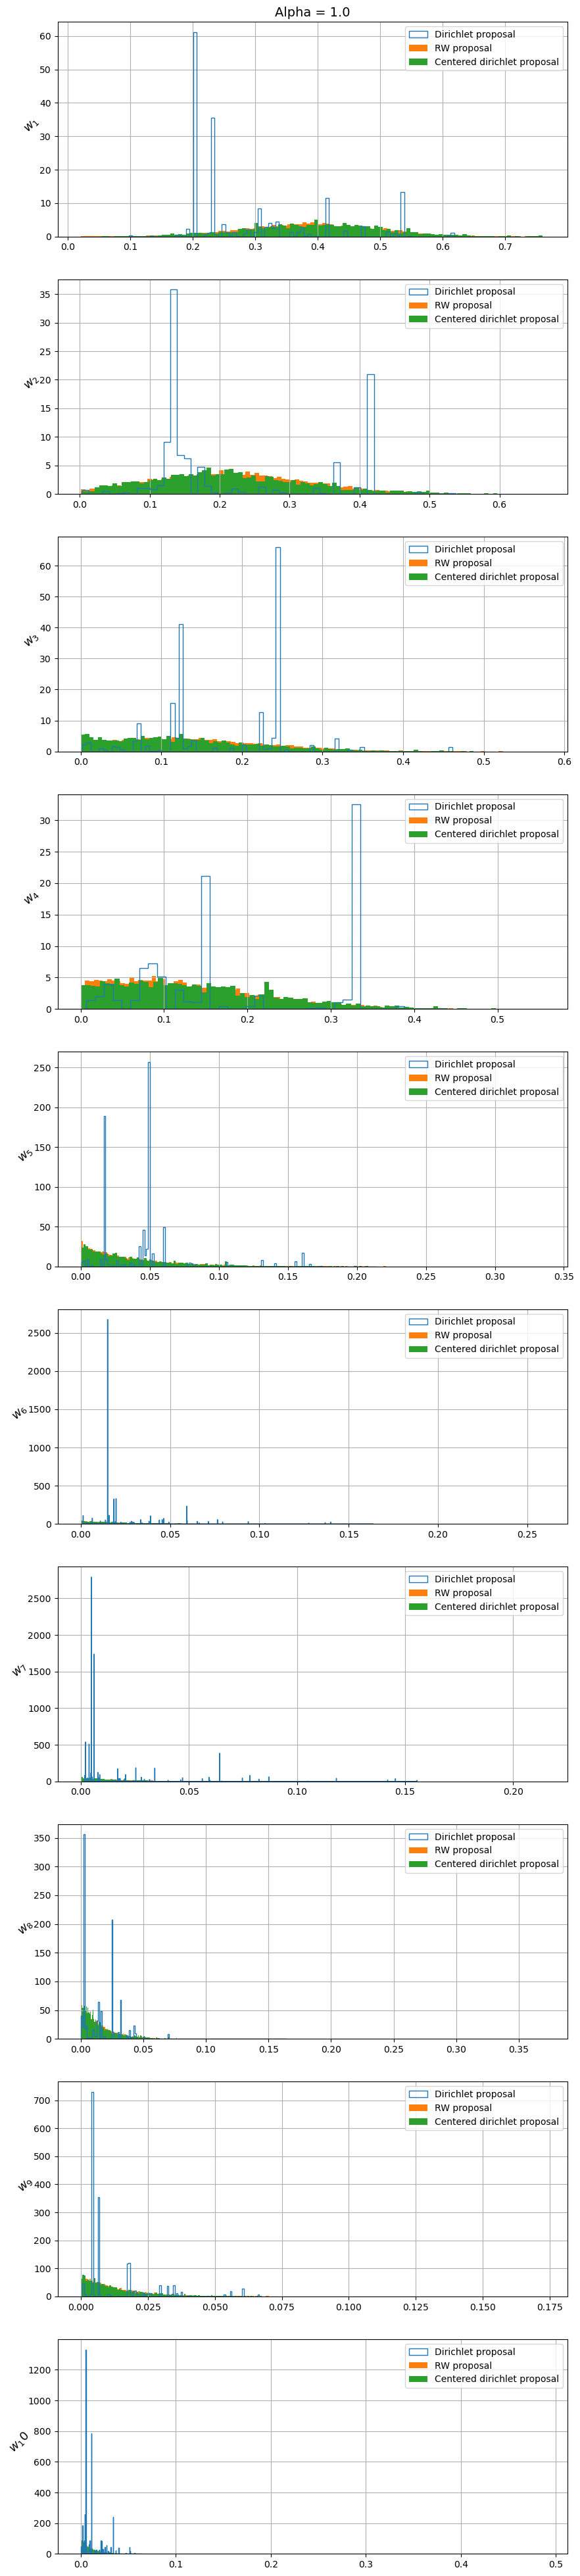

In [58]:
fig, axs = plt.subplots( n_pars, figsize = [10,5*n_pars] )
w = samples
w2 = samples2
w3 = samples3
x = np.arange(0, len(w[0]))
for i in range(n_pars):
    axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
    axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
    axs[i].hist(np.transpose(w3)[i], bins = 'auto', density = True, label = 'Centered dirichlet proposal')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    axs[i].grid()
    axs[i].legend()
    #axs[i].set_ylim([0,100])
axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
#plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()

100%|██████████| 10/10 [00:00<00:00, 19.96it/s]


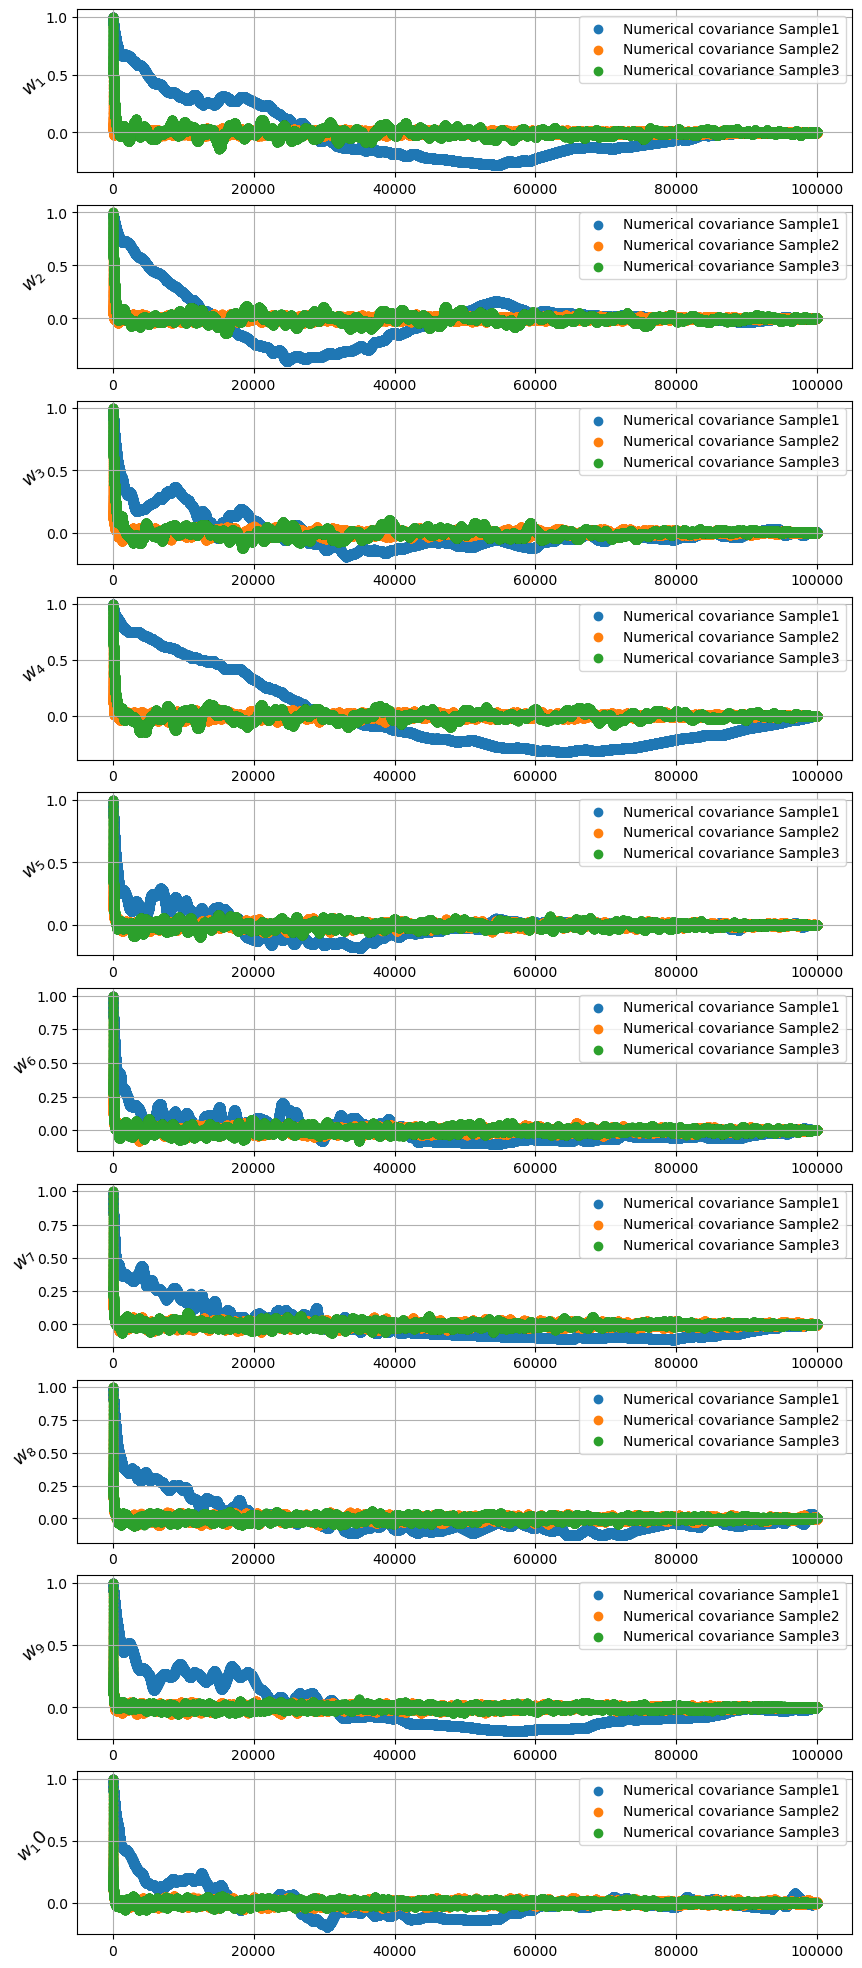

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [59]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i
    
def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

smp = np.transpose(samples)
smp2 = np.transpose(samples2)
smp3 = np.transpose(samples3)
nn = len(samples)
cors = np.zeros((n_pars,nn))
cors2 = np.zeros((n_pars,nn))
cors3 = np.zeros((n_pars,len(samples3)))

fig, axs = plt.subplots( n_pars, figsize = [10,2.5*n_pars] )
x = np.arange(0, nn)
for i in tqdm.tqdm( range(n_pars) ):
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    cors[i] = autocorr_func_1d(smp[i], norm=True)
    axs[i].scatter(x, cors[i], label = 'Numerical covariance Sample1')
    cors2[i] = autocorr_func_1d(smp2[i], norm=True)
    axs[i].scatter(x, cors2[i], label = 'Numerical covariance Sample2')
    cors3[i] = autocorr_func_1d(smp3[i], norm=True)
    axs[i].scatter(np.arange(0, len(samples3)), cors3[i], label = 'Numerical covariance Sample3')
    axs[i].grid()
    axs[i].legend()
plt.show()
plt.close()
taus = 1 + 2*np.sum(cors, axis = 1)
print(taus)

100%|██████████| 10/10 [00:00<00:00, 54.43it/s]


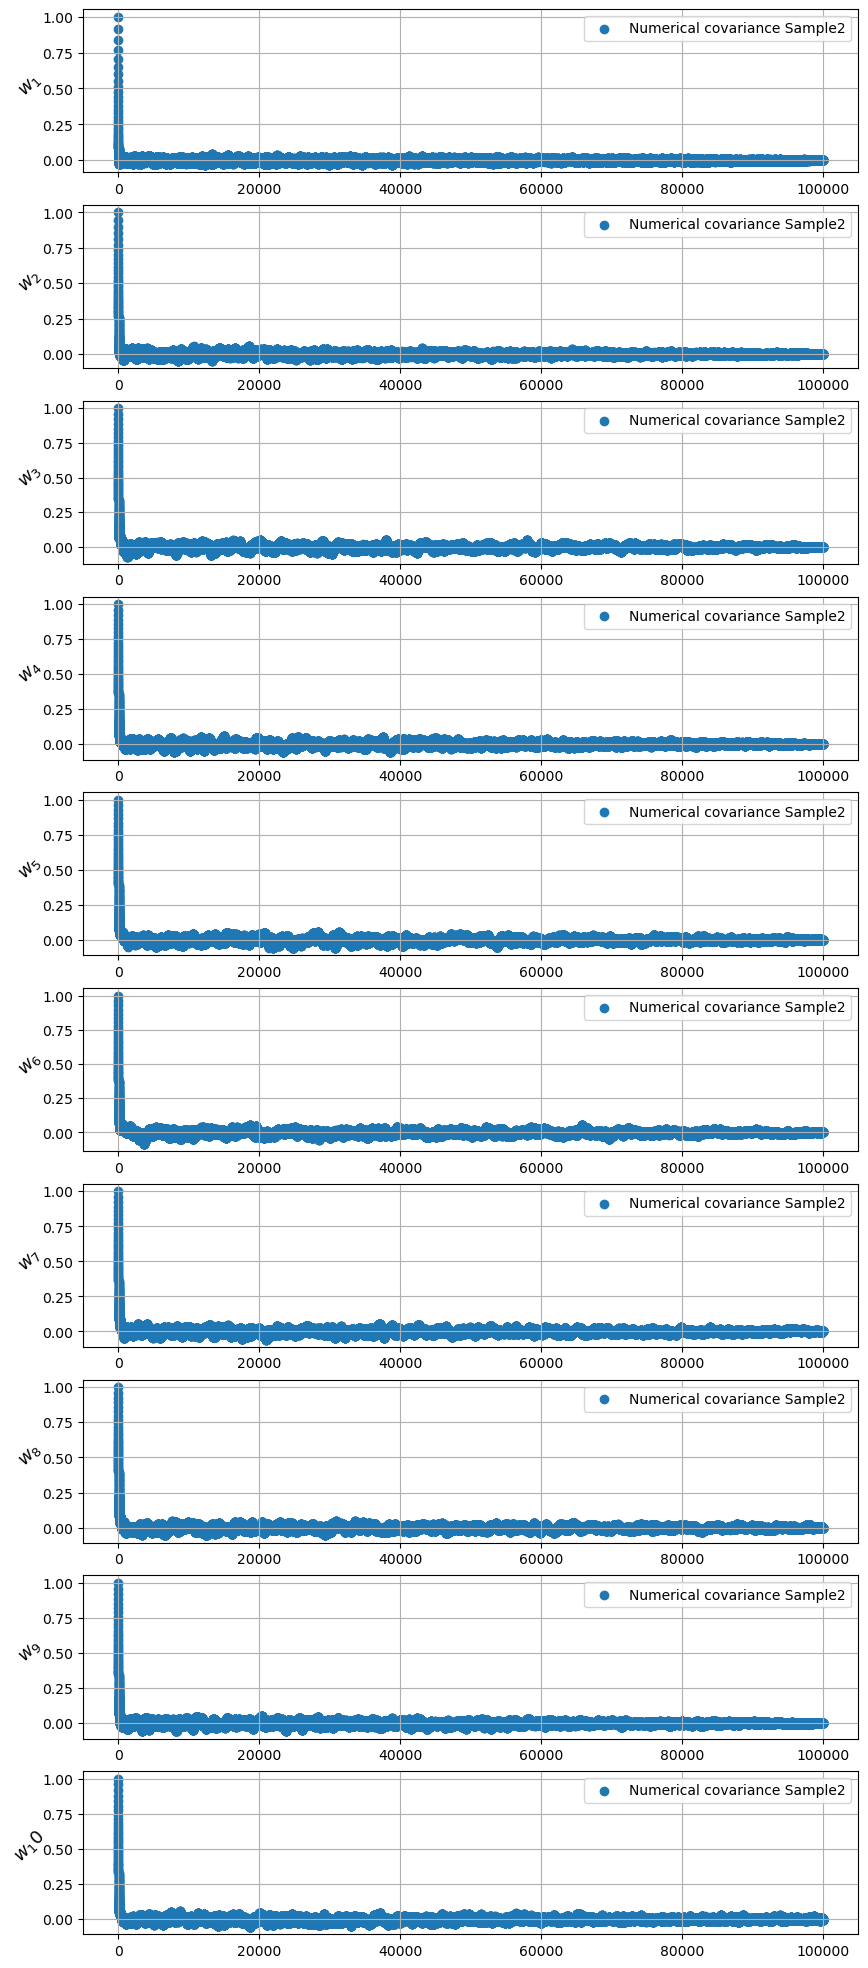

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [60]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i
    
def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

smp = np.transpose(samples2)
nn = len(samples2)
cors = np.zeros((n_pars,nn))

fig, axs = plt.subplots( n_pars, figsize = [10,2.5*n_pars] )
x = np.arange(0, nn)
for i in tqdm.tqdm( range(n_pars) ):
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    cors[i] = autocorr_func_1d(smp[i], norm=True)
    axs[i].scatter(x, cors[i], label = 'Numerical covariance Sample2')
    axs[i].grid()
    axs[i].legend()
plt.show()
plt.close()
taus = 1 + 2*np.sum(cors, axis = 1)
print(taus)